In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv("wind/wind_speed_raw.csv", index_col=0)
df["date"] = pd.to_datetime(df["date"])
df

,date,lon,lat,u,v,windvelo
0,2007-01-01,116.5,21.50,-8.257035,-8.363728,11.752896
1,2007-01-01,116.5,21.25,-8.253843,-8.440760,11.805607
2,2007-01-01,116.5,21.00,-8.257744,-8.500746,11.851288
3,2007-01-01,116.5,20.75,-8.290377,-8.566961,11.921542
4,2007-01-01,116.5,20.50,-8.343582,-8.631209,12.004713
...,...,...,...,...,...,...
536755,2020-12-01,127.5,5.00,-0.639788,-1.543960,1.671269
536756,2020-12-01,127.5,4.75,-0.479817,-1.541665,1.614607
536757,2020-12-01,127.5,4.50,-0.296790,-1.533798,1.562249
536758,2020-12-01,127.5,4.25,-0.096029,-1.499708,1.502779


In [3]:
m_df = df.groupby(["lat", "lon"])[["windvelo"]].mean().reset_index()
m_df

,lat,lon,windvelo
0,4.0,116.50,0.338913
1,4.0,116.75,0.286588
2,4.0,117.00,0.225665
3,4.0,117.25,0.362051
4,4.0,117.50,0.607744
...,...,...,...
3190,21.5,126.50,5.570037
3191,21.5,126.75,5.548037
3192,21.5,127.00,5.508153
3193,21.5,127.25,5.490218


In [4]:
target_df = m_df[(m_df["windvelo"] == m_df["windvelo"].max()) \
                 | (m_df["windvelo"] == m_df["windvelo"].min())].reset_index(drop=True)
target_df

,lat,lon,windvelo
0,4.00,117.00,0.225665
1,18.75,120.25,7.578876


In [256]:
ph_map_center = [12.8797, 121.7740]
def plot_wind_velo_values(df):
    ph_map = folium.Map(location=ph_map_center, tiles="cartodbpositron", max_bounds=True, zoom_start=5)
    df.apply(lambda x :
             folium.Marker([x.lat, x.lon],
                           tooltip="lat: " + str(x.lat) + ", lon: " + str(x.lon) + ", v: " + str(x.windvelo)) \
                           .add_to(ph_map),
             axis=1)
    return ph_map

In [5]:
range_df = m_df[((m_df["windvelo"] <= 6.5) & (m_df["windvelo"] >= 5.7)) \
                 | ((m_df["windvelo"] <= 0.5) & (m_df["windvelo"] >= 0.2))].reset_index(drop=True)
range_df

,lat,lon,windvelo
0,4.00,116.50,0.338913
1,4.00,116.75,0.286588
2,4.00,117.00,0.225665
3,4.00,117.25,0.362051
4,4.25,116.50,0.433326
...,...,...,...
462,21.50,124.00,5.778361
463,21.50,124.25,5.755345
464,21.50,124.50,5.706777
465,21.50,125.00,5.707020


In [6]:
# plot_wind_velo_values(range_df)

In [7]:
maxv_df = df[(df.lon == 122.0) \
             & (df.lat == 11.75)].set_index("date", drop=True)
maxv_df

,lon,lat,u,v,windvelo
date,,,,,
2007-01-01,122.0,11.75,-8.675939,-6.082933,10.595942
2007-02-01,122.0,11.75,-7.929644,-5.388664,9.587333
2007-03-01,122.0,11.75,-8.167650,-3.175066,8.763079
2007-04-01,122.0,11.75,-7.217046,-2.698781,7.705139
2007-05-01,122.0,11.75,-0.899076,0.120581,0.907126
...,...,...,...,...,...
2020-08-01,122.0,11.75,2.217699,2.418094,3.281062
2020-09-01,122.0,11.75,0.854930,1.013822,1.326175
2020-10-01,122.0,11.75,1.691320,0.684060,1.824418


In [8]:
minv_df = df[(df.lon == 124.75) \
             & (df.lat == 6.75)].set_index("date", drop=True)
minv_df

,lon,lat,u,v,windvelo
date,,,,,
2007-01-01,124.75,6.75,-0.081486,-0.046266,0.093704
2007-02-01,124.75,6.75,-0.265931,0.045844,0.269854
2007-03-01,124.75,6.75,-0.381564,-0.262938,0.463388
2007-04-01,124.75,6.75,-0.339000,-0.197707,0.392440
2007-05-01,124.75,6.75,0.076357,-0.071834,0.104836
...,...,...,...,...,...
2020-08-01,124.75,6.75,0.094802,0.056661,0.110444
2020-09-01,124.75,6.75,0.001515,0.168112,0.168118
2020-10-01,124.75,6.75,0.260803,-0.323908,0.415854


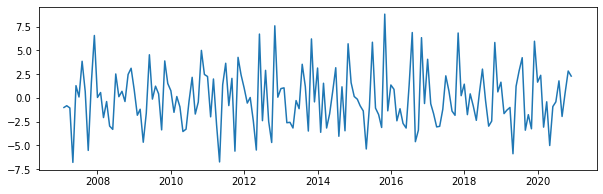

In [9]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)

plt.plot(maxv_df["windvelo"].interpolate().diff()[1:])

[[ 1.          1.        ]
 [-0.264135    0.03919814]
 [-0.2612512   0.04589488]
 [-0.32744193 -0.01684191]
 [-0.19576511  0.12349256]
 [-0.14794438  0.17168942]
 [-0.26981318  0.04986119]
 [-0.20702861  0.1161082 ]
 [-0.15483542  0.16888932]
 [-0.27958017  0.0441586 ]
 [-0.27668996  0.05096316]
 [-0.13566948  0.19554143]
 [ 0.34476559  0.67622536]]
[1.42515701e-01 1.26576294e-01 2.63436460e-02 5.05865387e-02
 9.12466331e-02 7.14035061e-02 1.01590931e-01 1.52209530e-01
 1.07113484e-01 8.02617341e-02 1.10731204e-01 3.58432152e-09]
[1.0, -0.11246842898863363, -0.10767816021069856, -0.17214191811272572, -0.0361362769375366, 0.011872517405957655, -0.1099759953330936, -0.04546020512333515, 0.007026949636128238, -0.11771078524810633, -0.11286339766241942, 0.02993597139714871, 0.5104954772438618]
3.5843215216854835e-09


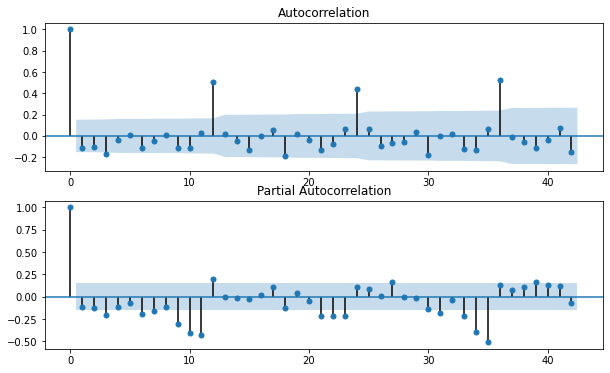

In [10]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

maxvdiff_df = maxv_df["windvelo"].interpolate().diff()[1:]
acf = plot_acf(maxvdiff_df, lags=42, ax=ax1)
pacf = plot_pacf(maxvdiff_df, lags=42, ax=ax2)
acf = sm.tsa.acf(maxvdiff_df, nlags=12, alpha=0.05, qstat=True, fft=False)
ci = acf[1]
print(ci)
pv = acf[3]
print(pv)
candidates = []
for i in range(len(ci)):
    candidates.append(np.mean(ci[i]))
print(candidates)
print(min(pv))

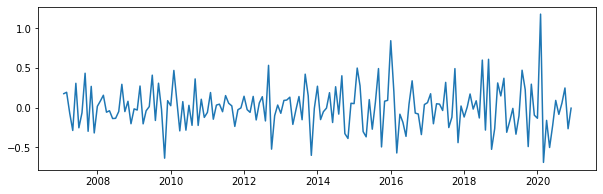

In [11]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)

plt.plot(minv_df["windvelo"].interpolate().diff()[1:])

In [12]:
def Convert(lst):
    res_dct = {i+1: lst[i] for i in range(0, len(lst))}
    return res_dct

[[ 1.          1.        ]
 [-0.42391238 -0.12057925]
 [-0.23734323  0.08769567]
 [-0.23663827  0.08998162]
 [-0.38806776 -0.05993661]
 [-0.04326513  0.29864673]
 [-0.12308773  0.22318411]
 [-0.07972763  0.26720915]
 [-0.23979549  0.109464  ]
 [-0.24868114  0.1016953 ]
 [-0.28976957  0.0620224 ]
 [-0.08352992  0.27163743]
 [ 0.00421465  0.36166635]]
[3.85465602e-04 1.13684630e-03 2.31480847e-03 1.16972362e-04
 8.87223856e-05 1.83355727e-04 2.19704818e-04 3.49947771e-04
 4.89403784e-04 3.92575882e-04 4.12232841e-04 7.92348384e-05]
[1.0, -0.2722458158969945, -0.07482377983683414, -0.07332832684044926, -0.22400218510701025, 0.1276907977503802, 0.050048192628362353, 0.09374075978707878, -0.065165745188522, -0.07349292269187968, -0.11387358561554513, 0.09405375437744545, 0.1829404993452602]
7.923483843090213e-05
{1: 0.00038546560222885525, 2: 0.0011368462958176071, 3: 0.0023148084732286045, 4: 0.00011697236224394468, 5: 8.872238562886336e-05, 6: 0.0001833557271555445, 7: 0.00021970481820643

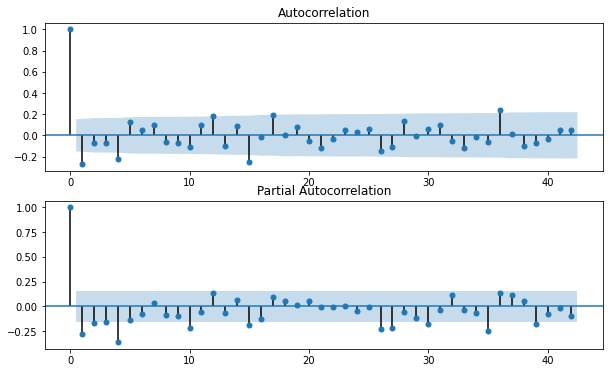

In [13]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

minvdiff_df = minv_df["windvelo"].interpolate().diff()[1:]
acf = plot_acf(minvdiff_df, lags=42, ax=ax1)
pacf = plot_pacf(minvdiff_df, lags=42, ax=ax2)
acf = sm.tsa.acf(minvdiff_df, nlags=12, alpha=0.05, qstat=True, fft=False)
ci = acf[1]
print(ci)
pv = acf[3]
print(pv)
candidates = []
for i in range(len(ci)):
    candidates.append(np.mean(ci[i]))
print(candidates)
print(min(pv))
pv = Convert(pv)
print(pv)
print(min(pv, key=pv.get))

In [14]:
maxv_train_df = maxv_df["2007-01-01":"2017-12-01"]
maxv_test_df = maxv_df["2018-01-01":]
minv_train_df = minv_df["2007-01-01":"2017-12-01"]
minv_test_df = minv_df["2018-01-01":]

In [15]:
len(maxv_train_df), len(maxv_test_df), len(minv_train_df), len(minv_test_df)

(132, 36, 132, 36)

In [16]:
def plot_original(train_df, test_df, feature):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    train_df[feature].plot(color="C7", ax=ax, label="train")
    test_df[feature].plot(color="C0", ax=ax, label="test")

    plt.legend()
    plt.ylabel("wind velocity at a sector")

In [17]:
def get_naive_forecast(df, start_date):
    return df.shift(1)[start_date:]

In [18]:
def get_windowed_forecast(df, start_date, roll_value=12):
    return df.rolling(roll_value).mean().shift(1)[start_date:]

In [19]:
def get_ema_forecast(df, start_date, alpha=0.7):
    # alpha = 1 is similar to naive
    return df.ewm(alpha=alpha).mean().shift(1)[start_date:]

In [20]:
def get_arima_fit(train_df, feature, order):
    model = ARIMA(endog=train_df[feature], order=order)  
    return model.fit()

In [21]:
def get_arima_forecast(model_fit, test_count, feature):
    return pd.DataFrame(model_fit.forecast(test_count, dynamic=True))\
                .rename(columns={"predicted_mean": feature})

In [22]:
def plot_forecast(train_df, test_df, forecast_df, feature):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    train_df[feature].plot(color="C7", ax=ax, label="train")
    test_df[feature].plot(color="C0", ax=ax, label="test")

    forecast_df[feature].plot(color="C1", ax=ax, label="forecast")

    plt.legend()
    plt.ylabel("wind velocity at a sector")

    print("The RMSE is %0.4f" % rmse(test_df[feature], forecast_df[feature]))
    print("The MAE is %0.4f" % meanabs(test_df[feature], forecast_df[feature]))
    print("The R2 score is %0.4f" % r2_score(test_df[feature], forecast_df[feature]))

In [23]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [24]:
def get_p_value(df):
    stationarity_test = adfuller(df, autolag="AIC", maxlag=20)
    return stationarity_test[1]

### Sector with Maximum Average Wind Velocity

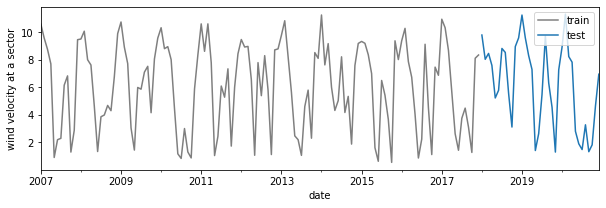

In [274]:
plot_original(maxv_train_df, maxv_test_df, "windvelo")

The RMSE is 2.7239
The MAE is 2.2261
The R2 score is 0.1958


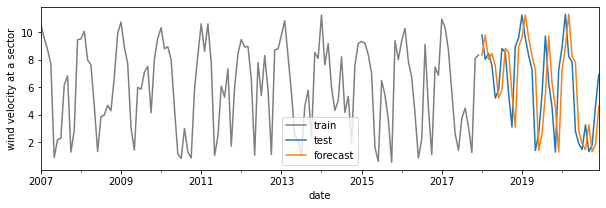

In [854]:
plot_forecast(maxv_train_df, maxv_test_df, get_naive_forecast(maxv_df, "2018-01-01"), "windvelo")

The RMSE is 3.0705
The MAE is 2.6165
The R2 score is -0.0219


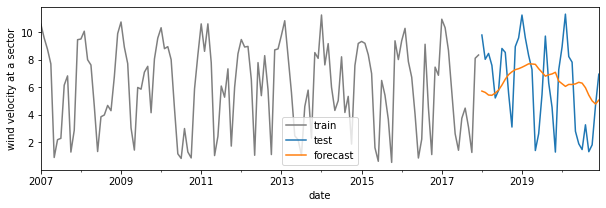

In [855]:
plot_forecast(maxv_train_df, maxv_test_df, get_windowed_forecast(maxv_df, "2018-01-01"), "windvelo") # yearly

The RMSE is 3.3867
The MAE is 2.8401
The R2 score is -0.2433


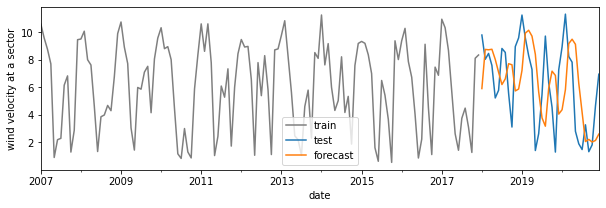

In [856]:
plot_forecast(maxv_train_df, maxv_test_df, get_windowed_forecast(maxv_df, "2018-01-01", 3), "windvelo") # quarterly

The RMSE is 2.8131
The MAE is 2.3645
The R2 score is 0.1422


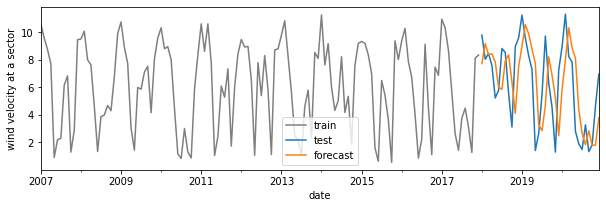

In [859]:
plot_forecast(maxv_train_df, maxv_test_df, get_ema_forecast(maxv_df, "2018-01-01"), "windvelo")

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum L

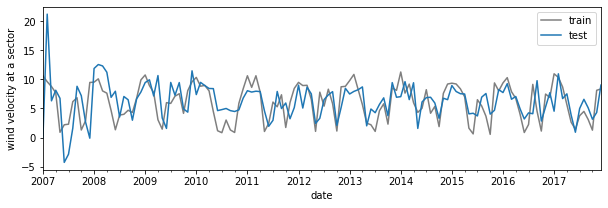

In [860]:
model_fit = get_arima_fit(maxv_train_df, "windvelo", (4, 3, 12))
fitted_df = pd.DataFrame(model_fit.fittedvalues).rename(columns={0: "windvelo"})
plot_original(maxv_train_df, fitted_df, "windvelo")

The RMSE is 3.1867
The MAE is 2.6249
The R2 score is -0.1008


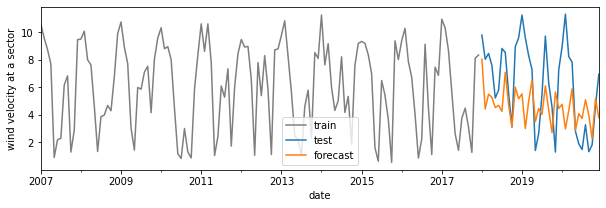

In [861]:
plot_forecast(maxv_train_df, maxv_test_df, get_arima_forecast(model_fit, len(maxv_test_df), "windvelo"), "windvelo")

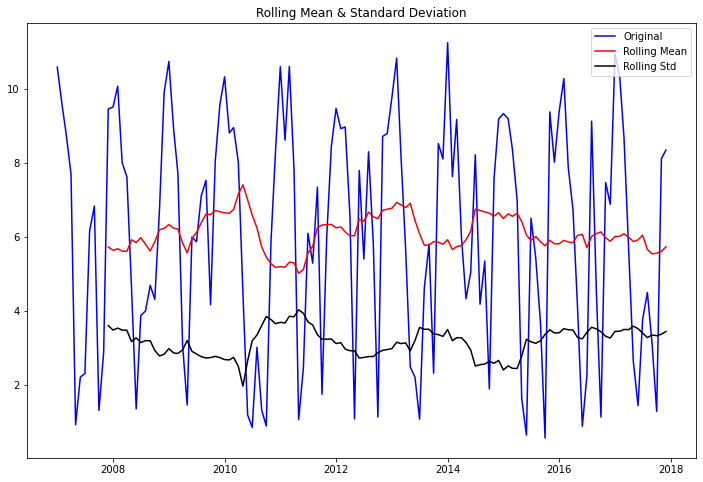

Results of Dickey-Fuller Test:
p-value = 0.0168. The series is likely non-stationary.
Test Statistic                  -3.259347
p-value                          0.016796
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
0.01679637074422085


In [25]:
test_stationarity(maxv_train_df["windvelo"], window=12)
print(get_p_value(maxv_train_df["windvelo"]))

            lon  lat         u         v  windvelo
date                                              
2007-02-01  0.0  0.0  0.746295  0.694269 -1.008609
2007-03-01  0.0  0.0 -0.238006  2.213597 -0.824254
2007-04-01  0.0  0.0  0.950604  0.476286 -1.057940
2007-05-01  0.0  0.0  6.317970  2.819362 -6.798013
2007-06-01  0.0  0.0 -1.298922 -0.162914  1.291280
...         ...  ...       ...       ...       ...
2020-08-01  0.0  0.0  3.551996  1.769763  1.797593
2020-09-01  0.0  0.0 -1.362769 -1.404272 -1.954887
2020-10-01  0.0  0.0  0.836390 -0.329761  0.498243
2020-11-01  0.0  0.0 -5.597923 -3.225172  2.835924
2020-12-01  0.0  0.0 -2.174684 -0.840793  2.298057

[167 rows x 5 columns]


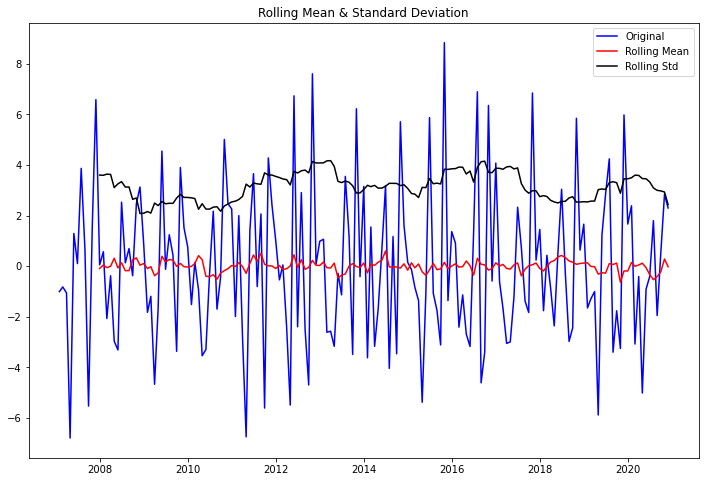

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.705991e+00
p-value                        1.301222e-11
#Lags Used                     1.100000e+01
Number of Observations Used    1.550000e+02
Critical Value (1%)           -3.473259e+00
Critical Value (5%)           -2.880374e+00
Critical Value (10%)          -2.576812e+00
dtype: float64


In [26]:
maxv_diff_df = maxv_df.diff().dropna()
print(maxv_diff_df)
test_stationarity(maxv_diff_df["windvelo"], window=12)

The RMSE is 3.1904
The MAE is 2.6814
The R2 score is -0.1033


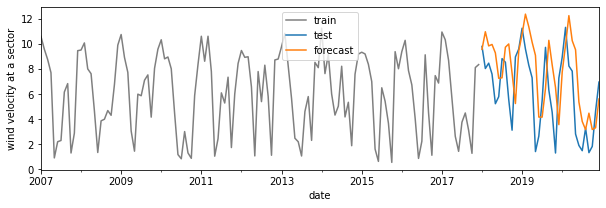

In [27]:
diff_df = get_ema_forecast(maxv_diff_df, "2018-01-01", alpha=0.8)
forecast_df = maxv_train_df.tail(1)
# print(maxv_test_df.head(10))
forecast_df = forecast_df.append(diff_df).cumsum().iloc[1:]
# print(forecast_df)
plot_forecast(maxv_train_df, maxv_test_df, forecast_df, "windvelo")

### Sector with Minimum Average Wind Velocity

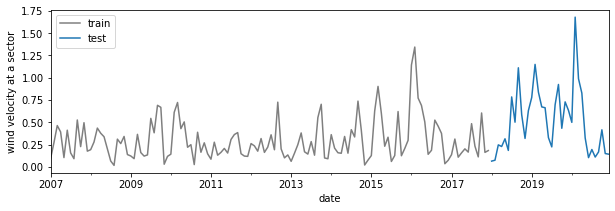

In [281]:
plot_original(minv_train_df, minv_test_df, "windvelo")

The RMSE is 0.3614
The MAE is 0.2720
The R2 score is 0.0072


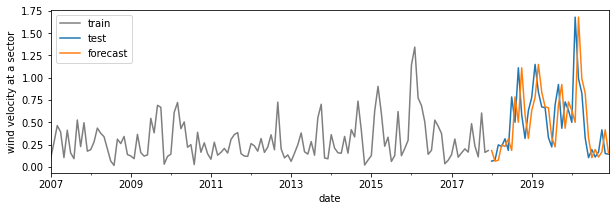

In [863]:
plot_forecast(minv_train_df, minv_test_df, get_naive_forecast(minv_df, "2018-01-01"), "windvelo")

The RMSE is 0.3755
The MAE is 0.2904
The R2 score is -0.0722


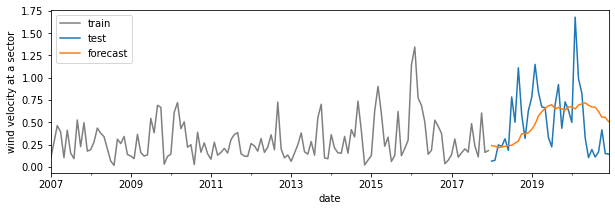

In [864]:
plot_forecast(minv_train_df, minv_test_df, get_windowed_forecast(minv_df, "2018-01-01"), "windvelo") # yearly

The RMSE is 0.3567
The MAE is 0.2634
The R2 score is 0.0324


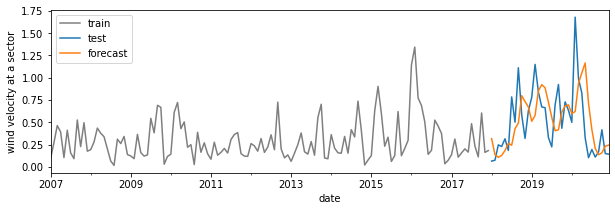

In [865]:
plot_forecast(minv_train_df, minv_test_df, get_windowed_forecast(minv_df, "2018-01-01", 3), "windvelo") # quarterly

The RMSE is 0.3341
The MAE is 0.2511
The R2 score is 0.1514


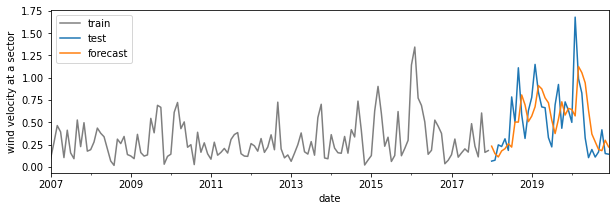

In [866]:
plot_forecast(minv_train_df, minv_test_df, get_ema_forecast(minv_df, "2018-01-01", alpha=0.5), "windvelo")

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: 

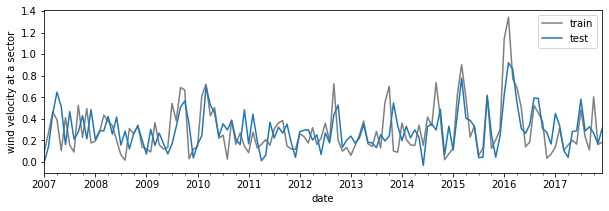

In [867]:
model_fit = get_arima_fit(minv_train_df, "windvelo", (12, 2, 24))
fitted_df = pd.DataFrame(model_fit.fittedvalues).rename(columns={0: "windvelo"})
plot_original(minv_train_df, fitted_df, "windvelo")

The RMSE is 0.3894
The MAE is 0.2868
The R2 score is -0.1529


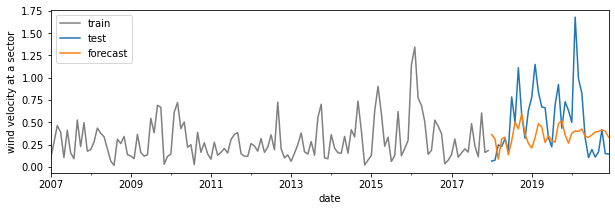

In [868]:
plot_forecast(minv_train_df, minv_test_df, get_arima_forecast(model_fit, len(minv_test_df), "windvelo"), "windvelo")

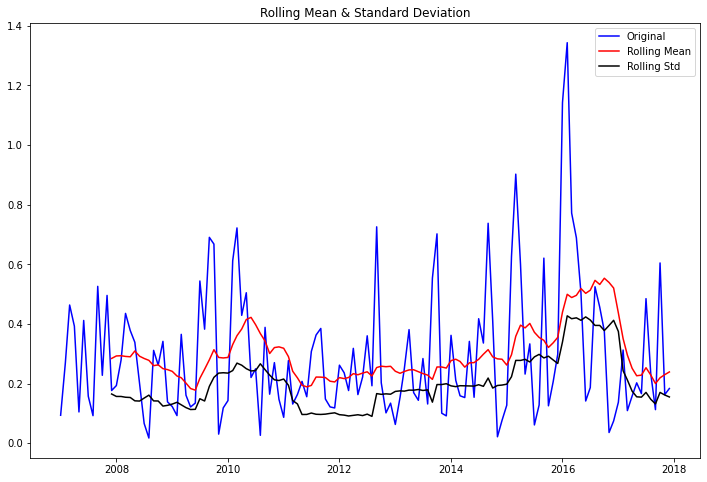

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.513218e+00
p-value                        3.964943e-11
#Lags Used                     0.000000e+00
Number of Observations Used    1.310000e+02
Critical Value (1%)           -3.481282e+00
Critical Value (5%)           -2.883868e+00
Critical Value (10%)          -2.578677e+00
dtype: float64


In [28]:
test_stationarity(minv_train_df["windvelo"], window=12)

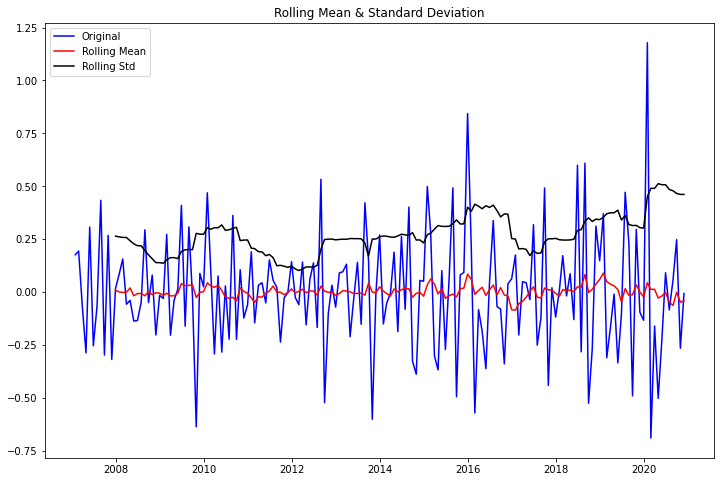

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -4.852767
p-value                          0.000043
#Lags Used                      15.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


In [29]:
minv_diff_df = minv_df.diff().dropna()
test_stationarity(minv_diff_df["windvelo"], window=12)

In [30]:
minv_diff_df["windvelo"]

date
2007-02-01    0.176150
2007-03-01    0.193534
2007-04-01   -0.070947
2007-05-01   -0.287604
2007-06-01    0.306771
                ...   
2020-08-01   -0.084688
2020-09-01    0.057674
2020-10-01    0.247736
2020-11-01   -0.265901
2020-12-01   -0.006814
Name: windvelo, Length: 167, dtype: float64

In [31]:
minv_df["windvelo"].interpolate().diff()

date
2007-01-01         NaN
2007-02-01    0.176150
2007-03-01    0.193534
2007-04-01   -0.070947
2007-05-01   -0.287604
                ...   
2020-08-01   -0.084688
2020-09-01    0.057674
2020-10-01    0.247736
2020-11-01   -0.265901
2020-12-01   -0.006814
Name: windvelo, Length: 168, dtype: float64

The RMSE is 0.3464
The MAE is 0.2566
The R2 score is 0.0875


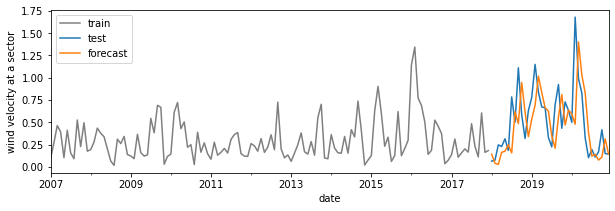

In [32]:
diff_df = get_ema_forecast(minv_diff_df, "2018-01-01", alpha=0.8)
forecast_df = minv_train_df.tail(1)
# print(minv_test_df.head(10))
forecast_df = forecast_df.append(diff_df).cumsum().iloc[1:]
# print(forecast_df)
plot_forecast(minv_train_df, minv_test_df, forecast_df, "windvelo")

In [363]:
def serialize_prophet(df, feature):
    df = df.reset_index()
    fb_df = pd.DataFrame(columns=["ds", "y"])
    fb_df["ds"] = pd.to_datetime(df["date"])
    fb_df["y"] = df[feature]
    return fb_df

In [381]:
def get_prophet_forecast(train_df, test_df):
    model = Prophet()
    model.fit(train_df)
    forecast = model.predict(test_df)
#     print(forecast.columns)
#     model.plot(forecast)
#     model.plot_components(forecast)
    return forecast

In [382]:
def unserialize_prophet(df, fb_feature, feature):
    df = df.rename(columns={"ds": "date", fb_feature: feature}).set_index("date", drop=True)
    return df[[feature]]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')
The RMSE is 2.1495
The MAE is 1.6662
The R2 score is 0.4992


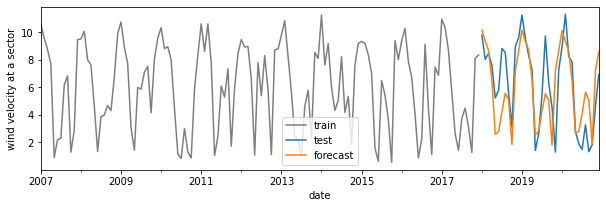

In [869]:
train_df = serialize_prophet(maxv_train_df, "windvelo")
test_df = serialize_prophet(maxv_test_df, "windvelo")
forecast_df = get_prophet_forecast(train_df, test_df)
forecast_y_df = unserialize_prophet(forecast_df, "yhat", "windvelo")
forecast_yl_df = unserialize_prophet(forecast_df, "yhat_lower", "windvelo")
forecast_yu_df = unserialize_prophet(forecast_df, "yhat_upper", "windvelo")
plot_forecast(maxv_train_df, maxv_test_df, forecast_y_df, "windvelo")
# plot_forecast(maxv_train_df, maxv_test_df, forecast_yl_df, "windvelo")
# plot_forecast(maxv_train_df, maxv_test_df, forecast_yu_df, "windvelo")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')
The RMSE is 0.3686
The MAE is 0.2885
The R2 score is -0.0331


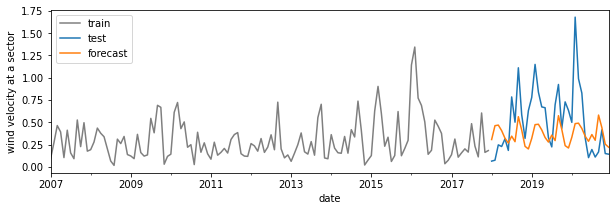

In [870]:
train_df = serialize_prophet(minv_train_df, "windvelo")
test_df = serialize_prophet(minv_test_df, "windvelo")
forecast_df = get_prophet_forecast(train_df, test_df)
forecast_y_df = unserialize_prophet(forecast_df, "yhat", "windvelo")
forecast_yl_df = unserialize_prophet(forecast_df, "yhat_lower", "windvelo")
forecast_yu_df = unserialize_prophet(forecast_df, "yhat_upper", "windvelo")
plot_forecast(minv_train_df, minv_test_df, forecast_y_df, "windvelo")
# plot_forecast(minv_train_df, minv_test_df, forecast_yl_df, "windvelo")
# plot_forecast(minv_train_df, minv_test_df, forecast_yu_df, "windvelo")

In [33]:
# convert an array of values into a dataset matrix
def prepare_for_lstm(df, look_back=1):
    X, Y = [], []
    for i in range(len(df)-look_back):
        X.append(df[i:(i+1)])
        Y.append(df[(i+look_back):(i+look_back+1)])
    return np.array(X), np.array(Y)

In [34]:
def unpack_forecast_matrix(lstm_matrix, test_df_pattern, scaler=None):
    forecast_len = len(lstm_matrix)
    forecast_df = test_df_pattern.iloc[:forecast_len]
    raw_forecast = []
    for i in range(forecast_len):
        raw_forecast.append(lstm_matrix[i][0])
    if scaler != None:
        raw_forecast = scaler.inverse_transform(raw_forecast)
    forecast_df.iloc[:, 1] = raw_forecast
    return forecast_df

In [35]:
def get_lstm_forecast(train_df, test_df, feature="windvelo", \
                      time_step=1, lstm_units=50, activation="relu", \
                      dense_units=1, epochs=100, verbose=0):
    trainX, trainY = prepare_for_lstm(train_df[[feature]], look_back=time_step)
    testX, testY = prepare_for_lstm(test_df[[feature]], look_back=0)

    # reshape input to be [sample count, time steps, feature count]
    trainX = np.reshape(trainX, (trainX.shape[0], time_step, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], time_step, testX.shape[1]))

    model = Sequential()
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True, \
                   input_shape=(testX.shape[1], testX.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=dense_units))
    model.compile(optimizer="adam", loss="mse")
    
    model.fit(trainX, trainY, epochs=epochs, verbose=verbose)

    # make predictions
    # trainPredict = model.predict(trainX)
    return model.predict(testX)

The RMSE is 1.4454
The MAE is 1.2430
The R2 score is 0.7735


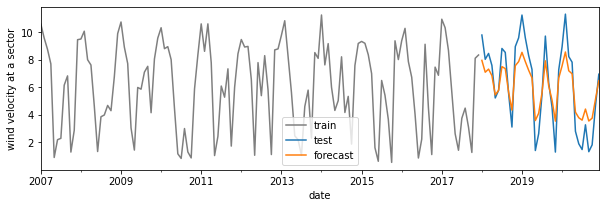

In [36]:
forecast_matrix = get_lstm_forecast(maxv_train_df.reset_index(), maxv_test_df.reset_index())
forecast_df = unpack_forecast_matrix(forecast_matrix, maxv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(maxv_train_df, maxv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 1.7011
The MAE is 1.5274
The R2 score is 0.6864


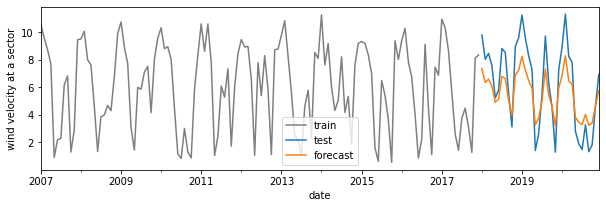

In [37]:
train_df = maxv_train_df.reset_index()
test_df = maxv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)

forecast_matrix = get_lstm_forecast(train_df, test_df)
forecast_df = unpack_forecast_matrix(forecast_matrix, maxv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(maxv_train_df, maxv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 1.6055
The MAE is 1.3974
The R2 score is 0.7206


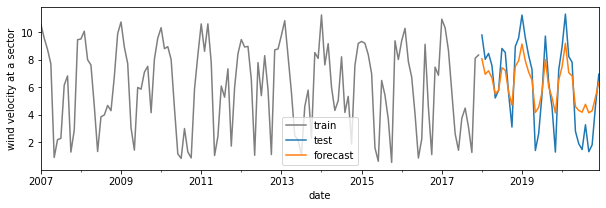

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df = maxv_train_df.reset_index()
test_df = maxv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)
train_df["windvelo"] = scaler.fit_transform(train_df[["windvelo"]])
test_df["windvelo"] = scaler.fit_transform(test_df[["windvelo"]])

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, maxv_test_df.reset_index()[["date", "windvelo"]], scaler)
plot_forecast(maxv_train_df, maxv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 0.2958
The MAE is 0.2341
The R2 score is 0.3346


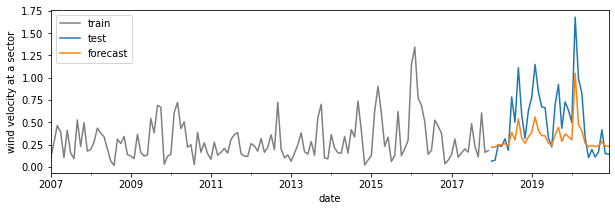

In [39]:
forecast_matrix = get_lstm_forecast(minv_train_df.reset_index(), minv_test_df.reset_index())
forecast_df = unpack_forecast_matrix(forecast_matrix, minv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(minv_train_df, minv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 0.2516
The MAE is 0.2018
The R2 score is 0.5187


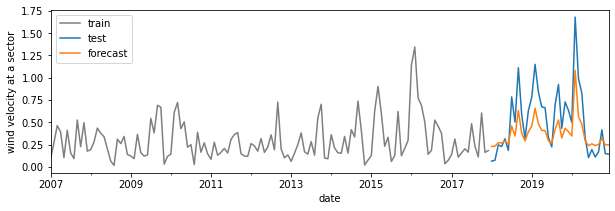

In [40]:
train_df = minv_train_df.reset_index()
test_df = minv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, minv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(minv_train_df, minv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 0.2123
The MAE is 0.1786
The R2 score is 0.6575


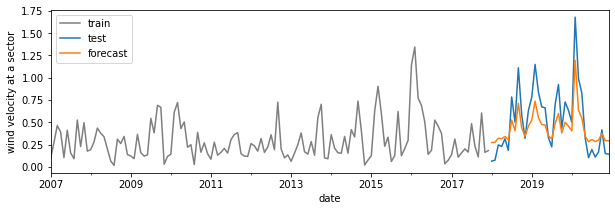

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df = minv_train_df.reset_index()
test_df = minv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)
train_df["windvelo"] = scaler.fit_transform(train_df[["windvelo"]])
test_df["windvelo"] = scaler.fit_transform(test_df[["windvelo"]])

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, minv_test_df.reset_index()[["date", "windvelo"]], scaler)
plot_forecast(minv_train_df, minv_test_df, forecast_df.set_index("date"), "windvelo")

In [44]:
th_train_df = minv_diff_df["2007-01-01":"2017-12-01"]
th_test_df = minv_diff_df["2018-01-01":]

scaler = MinMaxScaler(feature_range=(0, 1))
train_df = th_train_df.reset_index()
test_df = th_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)
train_df["windvelo"] = scaler.fit_transform(train_df[["windvelo"]])
test_df["windvelo"] = scaler.fit_transform(test_df[["windvelo"]])

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, th_test_df.reset_index()[["date", "windvelo"]], scaler)

In [51]:
minv_train_df

,lon,lat,u,v,windvelo
date,,,,,
2007-01-01,124.75,6.75,-0.081486,-0.046266,0.093704
2007-02-01,124.75,6.75,-0.265931,0.045844,0.269854
2007-03-01,124.75,6.75,-0.381564,-0.262938,0.463388
2007-04-01,124.75,6.75,-0.339000,-0.197707,0.392440
2007-05-01,124.75,6.75,0.076357,-0.071834,0.104836
...,...,...,...,...,...
2017-08-01,124.75,6.75,0.208307,-0.105925,0.233691
2017-09-01,124.75,6.75,0.092673,0.063873,0.112553
2017-10-01,124.75,6.75,0.428577,-0.426180,0.604407


            windvelo
date                
2018-01-01  0.301792
2018-02-01  0.412723
2018-03-01  0.514007
2018-04-01  0.626588
2018-05-01  0.732999
2018-06-01  0.852065
2018-07-01  0.926817
2018-08-01  1.054513
2018-09-01  1.128614
2018-10-01  1.269523
2018-11-01  1.396253
2018-12-01  1.489062
2019-01-01  1.591800
2019-02-01  1.680968
2019-03-01  1.810203
2019-04-01  1.931278
2019-05-01  2.043340
2019-06-01  2.173911
2019-07-01  2.291466
2019-08-01  2.374301
2019-09-01  2.472213
2019-10-01  2.611266
2019-11-01  2.705031
2019-12-01  2.822090
2020-01-01  2.941358
2020-02-01  2.977990
2020-03-01  3.127481
2020-04-01  3.248287
2020-05-01  3.387964
2020-06-01  3.512159
2020-07-01  3.618299
2020-08-01  3.734741
2020-09-01  3.842854
2020-10-01  3.939549
2020-11-01  4.066296
2020-12-01  4.178206
The RMSE is 2.0877
The MAE is 1.6963
The R2 score is -32.1377


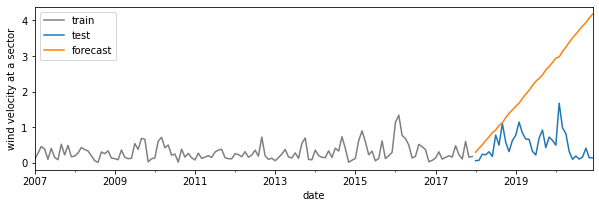

In [54]:
th_forecast_df = minv_train_df[["windvelo"]].tail(1)
th_forecast_df = th_forecast_df.append(forecast_df.set_index("date")).cumsum().iloc[1:]
print(th_forecast_df)
plot_forecast(minv_train_df, minv_test_df, th_forecast_df, "windvelo")